In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


In [5]:
Data= pd.read_excel('(2022-11-21)_왓섭.xlsx')
Data=Data[Data['별점']<=4]

## Bar plot

In [6]:
df_count=pd.DataFrame(Data.groupby('별점')['리뷰내용'].count()).reset_index()

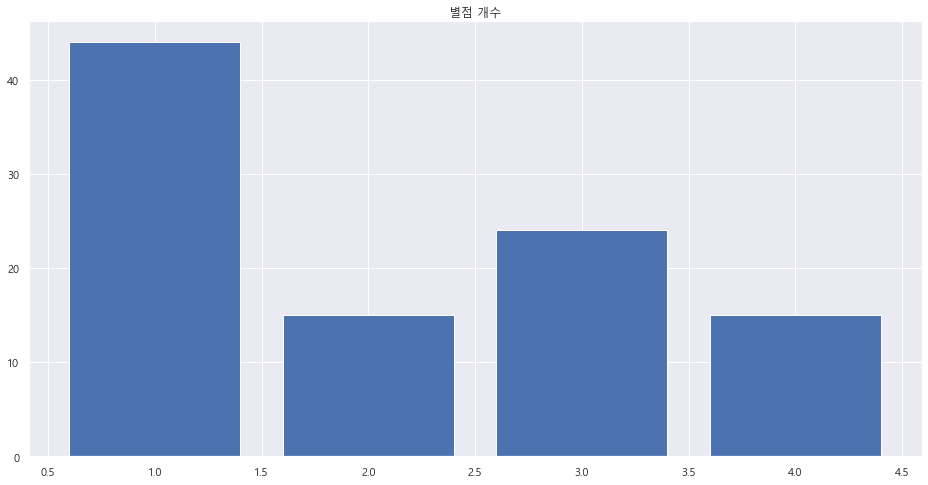

In [7]:
plt.figure(figsize=(16,8))
plt.bar(df_count['별점'],df_count['리뷰내용'])
plt.title('별점 개수')
plt.show()

## LDA
참고: https://happy-obok.tistory.com/5 / https://dacon.io/competitions/official/235590/codeshare/1078

In [8]:
from gensim import corpora

In [9]:
#특정 열의 값 별 몇 개의 행이 있는지 세기

element_count = {}

for item in Data['별점']:
    element_count.setdefault(item,0)
    element_count[item] += 1
    
count = pd.DataFrame.from_dict(element_count, orient = 'index',columns=["count"])
count

,count
4,15
1,44
2,15
3,24


In [10]:
#데이터 프레임의 'text' 열의 값들을 str 형식으로 바꾸기
Data.별점 = Data.별점.astype(str)

#text와 timestamp 열을 기준으로 중복된 데이터를 삭제, inplace : 데이터 프레임을 변경할지 선택(원본을 대체)
#Data.drop_duplicates(subset=['text','timestamp'], inplace=True)

#한글이 아니면 빈 문자열로 바꾸기
Data['리뷰내용'] = Data['리뷰내용'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True)

#빈 문자열 NAN 값으로 바꾸기
Data = Data.replace({'': np.nan})
Data = Data.replace(r'^\s*$', None, regex=True)

#NAN 이 있는 행은 삭제
Data.dropna(how='any', inplace=True)

#인덱스 차곡차곡
Data = Data.reset_index (drop = True)

#데이터 프레임에 null 값이 있는지 확인
print(Data.isnull().values.any()) 

False


In [11]:
#텍스트 데이터를 리스트로 변환
Data_list=Data['리뷰내용'].values.tolist()

In [12]:
#pip install konlpy
#konlpy 설치

In [13]:
from konlpy.tag import Kkma
kkma=Kkma()
#https://mr-doosun.tistory.com/22

In [14]:
#텍스트 데이터를 리스트로 변환
Data_list=Data.리뷰내용.values.tolist()
#리스트를 요소별로(트윗 하나) 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
for i in range(len(Data_list)):
    try:
        data_word.append(kkma.nouns(Data_list[i]))
    except Exception as e:
        continue

#data_word

In [15]:
#pip install gensim

from collections import Counter
from konlpy.tag import Okt
okt = Okt()
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel 

mallet 설정: https://github.com/RaRe-Technologies/gensim/issues/2163

In [16]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

mallet_path = 'C:/mallet-2.0.8/bin/mallet'

In [17]:
id2word=corpora.Dictionary(data_word)
id2word.filter_extremes(no_below = 3) #3회 이하로 등장한 단어는 삭제
texts = data_word
corpus=[id2word.doc2bow(text) for text in texts]

#mallet_path = 'C:\\mallet-2.0.8\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()


def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_word, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=21, step=2)

In [20]:

limit=21; start=4; step=2;
x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1

        
# Select the model and print the topics
optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)
#print(optimal_model.print_topics(num_words=10))








def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, Data['리뷰내용'],Data['별점']], axis=1)
    return(sent_topics_df)



Num Topics = 4  has Coherence Value of 0.4108752429121144
Num Topics = 6  has Coherence Value of 0.4704643595193254
Num Topics = 8  has Coherence Value of 0.4740303653174151
Num Topics = 10  has Coherence Value of 0.47346642981320636
Num Topics = 12  has Coherence Value of 0.48393474556603416
Num Topics = 14  has Coherence Value of 0.4570167194200458
Num Topics = 16  has Coherence Value of 0.4752238360322591
Num Topics = 18  has Coherence Value of 0.4933029804555654
Num Topics = 20  has Coherence Value of 0.4815506709324727


In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=Data_list)

# Format
df_topic_tweet = df_topic_sents_keywords.reset_index()
df_topic_tweet.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','', '리뷰내용','별점']

# Show각 문서에 대한 토픽
#df_dominant_topic=df_dominant_topic.sort_values(by=['Dominant_Topic'])
#df_topic_tweet



# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=["Topic_Num", "Topic_Perc_Contrib", "Keywords", '리뷰내용','별점',"Num_Documents", "Perc_Documents"]
lda_inform = lda_inform[["Topic_Num","Keywords","Num_Documents","Perc_Documents"]]
lda_inform
#lda_inform.Topic_Num = lda_inform.Topic_Num.astype(int)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'] +1
lda_inform.Topic_Num = lda_inform.Topic_Num.astype(str)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'].str.split('.').str[0]
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'] +1
df_topic_tweet.Dominant_Topic = df_topic_tweet.Dominant_Topic.astype(str)
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'].str.split('.').str[0]

<class 'pandas.core.frame.DataFrame'>


In [23]:
lda_inform.to_csv ("lda_inform14.csv",encoding='ANSI', index = None)
lda_inform

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0.0,1,"계좌, 뱅크, 글, 수, 때, 아이디, 핸드폰, 월, 부분, 필요",8,0.0816
1.0,2,"등록, 페, 로그인, 공동인증서, 느낌, 네이버페, 사용, 듯, 정기구독, 주세",8,0.0816
2.0,3,"공인인증서, 정보, 해지, 관리, 주세, 인, 하라, 자동, 때문, 이거",4,0.0408
3.0,4,"번호, 아이디, 비밀번호, 비밀, 은행, 이용, 입력, 설정, 점, 핸드폰",10,0.1020
4.0,5,"기능, 등록, 정기, 구독서비스, 동안, 경우, 하, 말, 어플, 연동",6,0.0612
5.0,6,"결제, 구, 내역, 사, 입력, 사람, 월, 이거, 인, 때",2,0.0204
6.0,7,"구독, 카드, 불편, 필요, 앱, 연결, 설정, 수동, 카드결제, 라",10,0.1020
7.0,8,"안, 네이버, 리뷰, 구독, 계속, 자동, 때문, 별, 카카오페, 설정",2,0.0204
8.0,9,"앱, 추가, 여, 구독정보, 단계, 별, 하나, 구독중, 네이버페, 구",4,0.0408
9.0,10,"거, 건, 번, 인증, 전화, 결제, 점, 정기, 공동인증서, 필요",6,0.0612


## 시각화

In [22]:
#pip install wordcloud-1.7.0-cp38-cp38-win_amd64.whl


In [42]:
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [71]:
processed_data=data_word
num_topics = 5
chunksize = 300
passes = 20
iterations = 400
eval_every = None
dictionary = corpora.Dictionary(processed_data)
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [72]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, 'file_name.html')

In [55]:
#pip install pyLDAvis

     ---------------------------------------- 1.7/1.7 MB 11.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 23.9/23.9 MB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 58.6/58.6 kB ? eta 0:00:00
  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136904 sha256=84f77d528380fda7e1a35c25b91b62d15579e6f452e5d3bf7c59f6e4936f1d57
  Stored in


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
